# Описание задачи
Необходимо создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.  
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.  
  
<b>Идея задачи от заказчика</b>:  
1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
    * Для модели выбрать тип виновника — только машина (car).  
    * Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
    * Для моделирования ограничиться данными за 2012 год — они самые свежие.  
    * Обязательное условие — учесть фактор возраста автомобиля.
2. На основе модели исследовать основные факторы ДТП.

# Импорты и константы

In [2]:
from time import time
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (fbeta_score, make_scorer, confusion_matrix,
                             recall_score, precision_score, roc_curve,
                             precision_recall_curve, PrecisionRecallDisplay)
from catboost import CatBoostClassifier

import warnings

In [3]:
RANDOM_STATE = 42
GSCV_LOG_REGRESSION_CONFIG = {
    'C': [.1, 1, 10, 50, 100, 250, 500, 1000],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2', 'elasticnet'],
}
GSCV_RAND_FOREST_CONFIG = {
    'max_depth': range(1, 11),
    'n_estimators': range(1, 202, 5),
}
GSCV_CAT_BOOSRT_CONFIG = {
    'learning_rate':[.1, .5, .8],
    'max_depth': range(1, 6),
    'n_estimators': range(50, 401, 50),
    'min_data_in_leaf': [50, 100, 150]
}
IS_TRAIN = False # Проводить ли заново подбор лучших параметров моделей

## Определение вспомогательных функций

In [4]:
def df_info(df):
    print('ОБЩАЯ ИНФОРМАЦИЯ')
    print('----------------')
    df.info()
    print('|' + 100 * '-' + '|')
    print()
    
    print('ПЕРВЫЕ 5 СТРОК ДАТАСЕТА')
    print('-----------------------')
    display(df.head())
    print('|' + 100 * '-' + '|')
    print()
    
    print('КОЛИЧЕСТВО ДУБЛИКАТОВ')
    print('---------------------')
    print(df.duplicated().sum())
    print('|' + 100 * '-' + '|')
    print()
    
    print('ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
    print('--------------------')
    print(df.isna().sum() / df.shape[0] * 100)
    print('|' + 100 * '-' + '|')
    print()
    
    print('КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ')
    print('-----------------------')
    for col in df.select_dtypes(include='object').columns.to_list():
        print(f'-- Уникальные признака {col} --')
        print('-------------------------------')
        print(df[col].unique())
        print()
    print('|' + 100 * '-' + '|')
    print()
      
    print('КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ')
    print('-----------------------')
    numeric = df.select_dtypes(include='number').columns.to_list()
    if numeric:
        display(df[numeric].describe())
        sns.heatmap(df[numeric].corr(), annot=True, fmt='.2f')
        

In [5]:
def create_violinplot(data, column):
    _, ax = plt.subplots()
    ax.xaxis.grid(True)
    sns.violinplot(
        data=data,
        x=column, ax=ax
    ).set_title(f'Распределение признака {column}')

In [6]:
def ohe(df, encoder, columns):
    encoder_categorical = pd.DataFrame(
        encoder.transform(df[columns]).toarray(),
        index=df.index,
        columns=encoder.get_feature_names_out()
    )
    df = df.join(encoder_categorical)
    df.drop(columns, inplace=True, axis=1)
    return df

In [7]:
def research_model(model, params, features, target, metric, cv=5):
    gscv = GridSearchCV(
        model, params, cv=cv,
        scoring=metric,
        refit=False,
        return_train_score=True,
        verbose=2
    )
    gscv.fit(features, target)
    return pd.DataFrame(gscv.cv_results_).sort_values(
        by='mean_test_score', ascending=False
    )

# Подключитесь к базе. Загрузите таблицы sql

In [8]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
} 


In [9]:
url_str = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(url_str)

# Проведите первичное исследование таблиц

Для первичного осмотка таблиц будем выгружать только первые 1000 строк, чтобы не тратить лишний трафик(вдруг он оплачивается компанией) и не забивать оперативную память таблицами, которые для решения задачи нам не понадобятся

## Таблица collisions

### Заявленное описание  
Общая информация о ДТП. Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
| Описание| Обозначение в таблице| Подробнее|
| :- | :- | :- |
| Идентификационный Номер в базе данных| CASE_ID| Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
| Дата происшествия| COLLISION_DATE| Формат год/месяц/день|
| Время происшествия| COLLISION_TIME| Формат: 24-часовой|
| Является ли место происшествие перекрёстком| INTERSECTION| <ul><li>Y — Intersection (перекрёсток)</li><li>N — Not Intersection (не перекрёсток)</li><li>-- — Not stated (Не указано)</li></ul>|
| Погода| WEATHER_1| <ul><li>A — Clear (Ясно)</li><li>B — Cloudy (Облачно)</li><li>C — Raining (Дождь)</li><li>D — Snowing (Снегопад)</li><li>E — Fog (Туман)</li><li>F — Other (Другое)</li><li>G — Wind (Ветер)</li><li>- — Not Stated (Не указано)</li></ul>|
| Серьёзность происшествия| COLLISION_DAMAGE| <ol><li>FATAL ТС (Не подлежит восстановлению)</li><li>SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)</li><li>MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)</li><li>SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)</li><li>SCRATCH (Царапина)</li></ol>|
| Основной фактор аварии| PRIMARY_COLL_FACTOR| <ul><li>A — Code Violation (Нарушение правил ПДД)</li><li>B — Other Improper Driving (Другое неправильное вождение)</li><li>C — Other Than Driver (Кроме водителя)</li><li>D — Unknown (Неизвестно)</li><li>E — Fell Asleep (Заснул)</li><li>- — Not Stated (Не указано)</li></ul> |
| Состояние дороги| ROAD_SURFACE| <ul><li>A — Dry (Сухая)</li><li>B — Wet (Мокрая)</li><li>C — Snowy or Icy (Заснеженная или обледенелая)</li><li>D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)</li><li>- — Not Stated (Не указано)</li></ul> |
| Освещение| LIGHTING| <ul><li> A — Daylight (Дневной свет)</li><li>B — Dusk-Dawn (Сумерки-Рассвет)</li><li>C — Dark-Street Lights (Темно-Уличные фонари)</li><li>D — Dark-No Street Lights (Темно-Нет уличных фонарей)</li><li>E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)</li><li>- — Not Stated (Не указано)</li></ul> |
|Номер географических районов, где произошло ДТП| COUNTY_CITY_LOCATION | число|
| Названия географических районов, где произошло ДТП| COUNTY_LOCATION | список разных названий, категориальный тип данных|
| Направление движения на перекрёстке| DIRECTION|<ul><li> N — North (Север)</li><li>E — East (Восток)</li><li>S — South (Юг)</li><li>W — West (Запад)</li><li>- or blank — Not State (Не указано)</li></ul> |
| Расстояние от главной дороги (метры)| DISTANCE| число |
| Тип дороги | LOCATION_TYPE | <ul><li>H — Highway (Шоссе)</li><li>I — Intersection (Перекрёсток)</li><li>R — Ramp (or Collector) (Рампа)</li><li>- or blank — Not State Highway (Не указано)</li></ul> |
| Количество участников| PARTY_COUNT | число |
| Категория нарушения | PCF_VIOLATION_CATEGORY | <ol><li> Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)</li><li>Impeding Traffic (Препятствие движению транспорта)</li><li> Unsafe Speed (Превышение скорости)</li> <li> Following Too Closely (Опасное сближение)</li> <li>Wrong Side of Road (Неправильная сторона дороги)</li> <li> Improper Passing (Неправильное движение)</li> <li> Unsafe Lane Change (Небезопасная смена полосы движения)</li> <li> Improper Turning (Неправильный поворот)</li> <li> Automobile Right of Way (Автомобильное право проезда)</li> <li> Pedestrian Right of Way (Пешеходное право проезда)</li> <li> Pedestrian Violation (Нарушение пешеходами)</li> <li> Traffic Signals and Signs (Дорожные сигналы и знаки)</li> <li> Hazardous Parking (Неправильная парковка)</li> <li> Lights (Освещение)</li> <li> Brakes (Тормоза)</li> <li> Other Equipment (Другое оборудование)</li> <li> Other Hazardous Violation (Другие нарушения)</li> <li> Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)</li> <li> Speeding (Скорость)</li> <li> Pedestrian dui (Нарушение пешехода)</li> <li> Unsafe Starting or Backing (Опасный старт)</li> <li> Other Improper Driving (Другое неправильное вождение)</li> <li> Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)</li> <li> Fell Asleep (Заснул)</li> <li> Unknown (Неизвестно)</li> <li>- — Not Stated (Не указано) </li></ol>|
| Тип аварии | TYPE_OF_COLLISION|<ul><li> A — Head-On (Лоб в лоб)</li><li>B — Sideswipe (Сторона)</li><li>C — Rear End (Столкновение задней частью)</li><li>D — Broadside (Боковой удар)</li><li>E — Hit Object (Удар объекта)</li><li>F — Overturned (Опрокинутый)</li><li>G — Vehicle (транспортное средство/ Пешеход)</li><li>H — Other (Другое)</li><li>- — Not Stated (Не указано)</li></ul> |
| Дополнительные участники ДТП | MOTOR_VEHICLE_INVOLVED_WITH | <ul><li> Other motor vehicle (Другой автомобиль)</li><li>Fixed object (Неподвижный объект)</li><li>Parked motor vehicle (Припаркованный автомобиль)</li><li>Pedestrian (Пешеход)</li><li>Parked motor vehicle (Припаркованный автомобиль)</li><li>Bicycle (Велосипедист)</li><li>Non-collision (Не столкновение)</li><li>Other object (Другой объект)</li><li>Motor vehicle on other roadway (Автомобиль на другой проезжей)</li><li>Animal (Животное)</li><li>Train (Поезд)</li></ul> |
| Дорожное состояние | ROAD_CONDITION_1 | <ul><li> A — Holes, Deep Ruts (Ямы, глубокая колея)</li><li>B — Loose Material on Roadway (Сыпучий материал на проезжей части)</li><li>C — Obstruction on Roadway (Препятствие на проезжей части)</li><li>D — Construction or Repair Zone (Зона строительства или ремонта)</li><li>E — Reduced Roadway Width (Уменьшенная ширина проезжей части)</li><li>F — Flooded (Затоплено)</li>G — Other (Другое)<li>H — No Unusual Condition (Нет ничего необычного)</li><li>- — Not Stated (Не указано)</li></ul> |
| Устройство управления| control_device|<ul><li> A — Functioning (Функционирует)</li><li>B — Not Functioning (Не функционирует)</li><li>C — Obscured (Затемнённый)</li><li>D — None (Нет)</li><li>- — Not Stated (Не указано)</li></ul> |

### Полученные данные

ОБЩАЯ ИНФОРМАЦИЯ
----------------
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4083072 to 4090305
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   county_city_location         1000 non-null   object 
 1   county_location              1000 non-null   object 
 2   distance                     1000 non-null   float64
 3   direction                    688 non-null    object 
 4   intersection                 990 non-null    float64
 5   weather_1                    990 non-null    object 
 6   location_type                329 non-null    object 
 7   collision_damage             1000 non-null   object 
 8   party_count                  1000 non-null   int64  
 9   primary_collision_factor     989 non-null    object 
 10  pcf_violation_category       975 non-null    object 
 11  type_of_collision            994 non-null    object 
 12  motor_vehicle_involved_with  996 non-n

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
case_id,,,,,,,,,,,,,,,,,,,
4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


|----------------------------------------------------------------------------------------------------|

КОЛИЧЕСТВО ДУБЛИКАТОВ
---------------------
0
|----------------------------------------------------------------------------------------------------|

ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
--------------------
county_city_location            0.0
county_location                 0.0
distance                        0.0
direction                      31.2
intersection                    1.0
weather_1                       1.0
location_type                  67.1
collision_damage                0.0
party_count                     0.0
primary_collision_factor        1.1
pcf_violation_category          2.5
type_of_collision               0.6
motor_vehicle_involved_with     0.4
road_surface                    1.1
road_condition_1                1.2
lighting                        0.6
control_device                  0.5
collision_date                  0.0
collision_time                  0.3
dtype: float

,distance,intersection,party_count
count,1000.000000,990.000000,1000.000000
mean,406.124000,0.300000,2.077000
std,1236.622258,0.458489,0.682302
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,2.000000
50%,60.000000,0.000000,2.000000
75%,300.000000,1.000000,2.000000
max,21120.000000,1.000000,8.000000


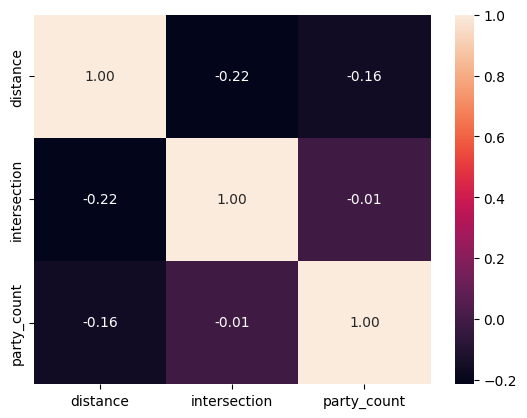

In [10]:
collisions = '''
SELECT *
FROM collisions
LIMIT 1000
'''

df_info(pd.read_sql_query(collisions, engine, index_col='case_id'))

Таблица практически соотвестсует заявленному описанию. Однако в полученной таблице вместо столбца `PRIMARY_COLL_FACTOR` предствален столбец `primary_collision_factor`. Значаниея в этом столбце также отличаются от описанных. Данные в столбце `intersection` представлены значения 0 и 1, а не так, как представлено в описании.  
В выгруженных 1000 строках нет дубликатов, однако присутствуют пропуски, что при дальнейшей работе необходимо учесть

## Таблица parties 

### Заявленное описание  
Информация об участниках ДТП. Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это `case_id and party_number`.
| Описание| Обозначение в таблице | Подробнее|
|:- |:- |:- |
| Идентификационный номер| ID| Уникальный идентификатор |
| Идентификационный номер в базе данных| CASE_ID| Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
| Номер участника происшествия | PARTY_NUMBER | От 1 до N — по числу участников происшествия |
| Тип участника происшествия | PARTY_TYPE | <ol><li> Car (Авто)</li> <li> Road bumper (Дорожные знаки)</li><li> Building (Строения)</li> <li> Road signs (Отбойник)</li> <li> Other (Другое)</li> <li> — Operator (Оператор)</li> <li>- — Not Stated (Не указано)</li></ol> |
| Виновность участника | AT_FAULT| 0/1 |
| Сумма страховки (тыс. $)| INSURANCE_PREMIUM| число |
| Состояние участника: физическое или с учётом принятых лекарств| PARTY_DRUG_PHYSICAL| <ul><li> E — Under Drug Influence (Под воздействием лекарств)</li><li>F — Impairment — Physical (Ухудшение состояния)</li><li>G — Impairment Unknown (Не известно)</li><li>H — Not Applicable (Не оценивался)</li><li>I — Sleepy/Fatigued (Сонный/Усталый)</li><li>- — Not Stated (Не указано) </li></ul>|
| Трезвость участника| PARTY_SOBRIETY| <ul><li> A — Had Not Been Drinking (Не пил)</li><li>B — Had Been Drinking, Under Influence (Был пьян, под влиянием)</li><li>C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)</li><li>D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)</li><li>G — Impairment Unknown (Неизвестно ухудшение)</li><li>H — Not Applicable (Не оценивался)</li><li>- — Not Stated (Не указано)</li></ul> |
| Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | CELLPHONE_IN_USE | 0/1 |

### Полученные данные

ОБЩАЯ ИНФОРМАЦИЯ
----------------
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 22 to 8867
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   case_id              1000 non-null   object 
 1   party_number         1000 non-null   int64  
 2   party_type           982 non-null    object 
 3   at_fault             1000 non-null   int64  
 4   insurance_premium    368 non-null    float64
 5   party_sobriety       901 non-null    object 
 6   party_drug_physical  539 non-null    object 
 7   cellphone_in_use     526 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 70.3+ KB
|----------------------------------------------------------------------------------------------------|

ПЕРВЫЕ 5 СТРОК ДАТАСЕТА
-----------------------


,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
id,,,,,,,,
22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
29,3899462,2,car,0,21.0,had not been drinking,None,0.0
31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


|----------------------------------------------------------------------------------------------------|

КОЛИЧЕСТВО ДУБЛИКАТОВ
---------------------
0
|----------------------------------------------------------------------------------------------------|

ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
--------------------
case_id                 0.0
party_number            0.0
party_type              1.8
at_fault                0.0
insurance_premium      63.2
party_sobriety          9.9
party_drug_physical    46.1
cellphone_in_use       47.4
dtype: float64
|----------------------------------------------------------------------------------------------------|

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
-----------------------
-- Уникальные признака case_id --
-------------------------------
['3899454' '3899462' '3899465' '3899478' '3899481' '3899505' '3899509'
 '3981292' '3982068' '3982887' '3982076' '3982892' '3982898' '3982910'
 '3982914' '3982918' '3982945' '3982946' '3982941' '3982949' '3982950'
 '3989728' '3984282' '3984

,party_number,at_fault,insurance_premium,cellphone_in_use
count,1000.000000,1000.000000,368.000000,526.000000
mean,2.088000,0.191000,37.616848,0.030418
std,0.941883,0.393286,19.497011,0.171899
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.750000,0.000000
50%,2.000000,0.000000,34.500000,0.000000
75%,2.000000,0.000000,52.000000,0.000000
max,9.000000,1.000000,90.000000,1.000000


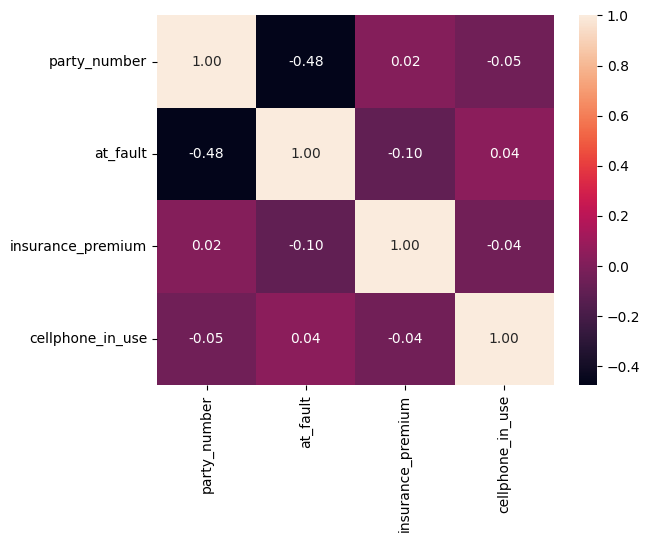

In [11]:
parties = '''
SELECT  *
FROM parties
LIMIT 1000
'''

df_info(pd.read_sql_query(parties, engine, index_col='id'))

Таблица соответсвует заявленному описанию. Часть признаков, которые стоит рассматривать, как категориальные, по умолчанию распознаются, как количественные. Этот момент необходимо будет учесть при дальнейшем исследовании. Также стоит учесть, что в данных имеются пропущенные значения

### Таблица vehicles

## Заявленное описание  
Информация о пострадавших машинах. Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Если нужен уникальный идентификатор, это `case_id and party_number`.
| Описание| Обозначение в таблице| Подробнее|
| :- | :- | :- |
| Индекс текущей таблицы | ID | Номер в таблице|
| Идентификационный номер в базе данных | CASE_ID | Уникальный номер для зарегистрированного происшествия в таблице происшествий.|
| Тип кузова | VEHICLE_TYPE | <ul><li> MINIVAN</li><li>COUPE</li><li>SEDAN</li><li>HATCHBACK</li><li>OTHER</li></ul>      |
| Тип КПП | VEHICLE_TRANSMISSION | <ul><li> auto (Автоматическая)</li><li>manual (Ручная)</li><li> - — Not Stated (Не указано)</li></ul> |
| Возраст автомобиля (в годах) | VEHICLE_AGE | число |

## Полученные данные

ОБЩАЯ ИНФОРМАЦИЯ
----------------
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1175713 to 1177641
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   case_id               1000 non-null   object 
 1   party_number          1000 non-null   int64  
 2   vehicle_type          1000 non-null   object 
 3   vehicle_transmission  992 non-null    object 
 4   vehicle_age           965 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.9+ KB
|----------------------------------------------------------------------------------------------------|

ПЕРВЫЕ 5 СТРОК ДАТАСЕТА
-----------------------


,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
id,,,,,
1175713,5305032,2,sedan,manual,3.0
1,3858022,1,sedan,auto,3.0
1175712,5305030,1,sedan,auto,3.0
1175717,5305033,3,sedan,auto,5.0
1175722,5305034,2,sedan,auto,5.0


|----------------------------------------------------------------------------------------------------|

КОЛИЧЕСТВО ДУБЛИКАТОВ
---------------------
0
|----------------------------------------------------------------------------------------------------|

ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
--------------------
case_id                 0.0
party_number            0.0
vehicle_type            0.0
vehicle_transmission    0.8
vehicle_age             3.5
dtype: float64
|----------------------------------------------------------------------------------------------------|

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
-----------------------
-- Уникальные признака case_id --
-------------------------------
['5305032' '3858022' '5305030' '5305033' '5305034' '5305046' '5305053'
 '5305060' '3899454' '5305071' '5305080' '5305035' '5305037' '5305040'
 '5305056' '5305058' '5305059' '5305066' '5305069' '5305079' '5305098'
 '5305101' '5307920' '5307931' '5307938' '4012051' '4014901' '4014908'
 '5324151' '5324163' '5324176' '5324177

,party_number,vehicle_age
count,1000.000000,965.000000
mean,1.642000,4.769948
std,0.711577,3.172909
min,1.000000,0.000000
25%,1.000000,2.000000
50%,2.000000,4.000000
75%,2.000000,7.000000
max,7.000000,15.000000


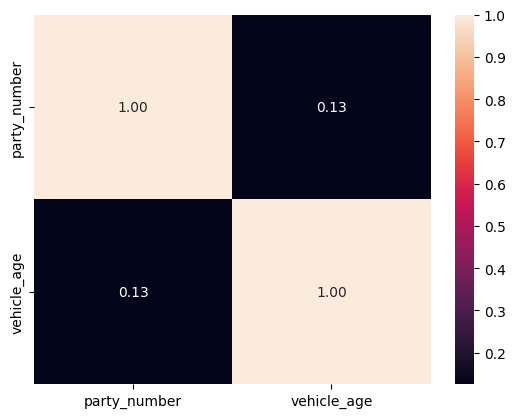

In [12]:
vehicles = '''
SELECT *
FROM vehicles
LIMIT 1000
'''
df_info(pd.read_sql_query(vehicles, engine, index_col='id'))

Таблица соответсвует заявленному описанию. Стоит учесть, что в данных имеются пропущенные значения.

Таблица Case_ids

In [13]:
case_ids = """
SELECT *
FROM case_ids
LIMIT 1000
"""
df_info(pd.read_sql_query(case_ids, engine))

ОБЩАЯ ИНФОРМАЦИЯ
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   case_id  1000 non-null   object
 1   db_year  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
|----------------------------------------------------------------------------------------------------|

ПЕРВЫЕ 5 СТРОК ДАТАСЕТА
-----------------------


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


|----------------------------------------------------------------------------------------------------|

КОЛИЧЕСТВО ДУБЛИКАТОВ
---------------------
0
|----------------------------------------------------------------------------------------------------|

ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
--------------------
case_id    0.0
db_year    0.0
dtype: float64
|----------------------------------------------------------------------------------------------------|

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
-----------------------
-- Уникальные признака case_id --
-------------------------------
['0081715' '0726202' '3858022' '3899441' '3899442' '3899445' '3899446'
 '3899449' '3899450' '3899453' '3899454' '3899457' '3899458' '3899462'
 '3899465' '3899466' '3899469' '3899470' '3899473' '3899474' '3899477'
 '3899478' '3899481' '3899482' '3899485' '3899486' '3899489' '3899490'
 '3899493' '3899494' '3899497' '3899498' '3899501' '3899502' '3899505'
 '3899506' '3899509' '3899510' '3899513' '3899514' '3899517' '3899518'
 '39189

Описания для данной таблице не было предоставлено. Однако полученные данные точно отличаются от ER-диаграммы. Что содержит столбец `db_year` не известно. В выгруженных данных он содержит только одно значение - 2021

## Вывод

Все заявленные таблицы пристутствуют в базе данных. Однако некоторые таблица отличаются от представленного описания. Также в таблице `case_ids` был обнаружен столбец `db_year`, которого нет в описании. Что за информация содержится в этом столбце неизвестно. Все таблицы содержат пропуски. Также в некоторых таблица требуется преобразование типов данных в столбцах.  
Также есть вопросы к постановке задачи и предоставленным данным. В базе данных содержится информация только о случаях случившихся ДТП, но нет информации о поездках без ДТП (не очень даже понятно, как собирать эту информацию). Поэтому придется придерживаться предположения заказчика: предстказывать виновность водителя. Однако на начальном этапе данная модель не выглядит очень полезной

#  Проведите статистический анализ факторов ДТП

## Изучение зависимости количества аварий от месяца

Выгрузим из БД информацию о том, какое количество аварий происходило в каждый месяц, представленный в БД

In [14]:
collisions_in_month_query = '''
SELECT DATE_TRUNC('month', collision_date)::date AS month,
       COUNT(case_id) AS collision
FROM collisions
GROUP BY DATE_TRUNC('month', collision_date)::date
'''
collisions_in_month = pd.read_sql_query(collisions_in_month_query, engine)
collisions_in_month.head()

,month,collision
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916


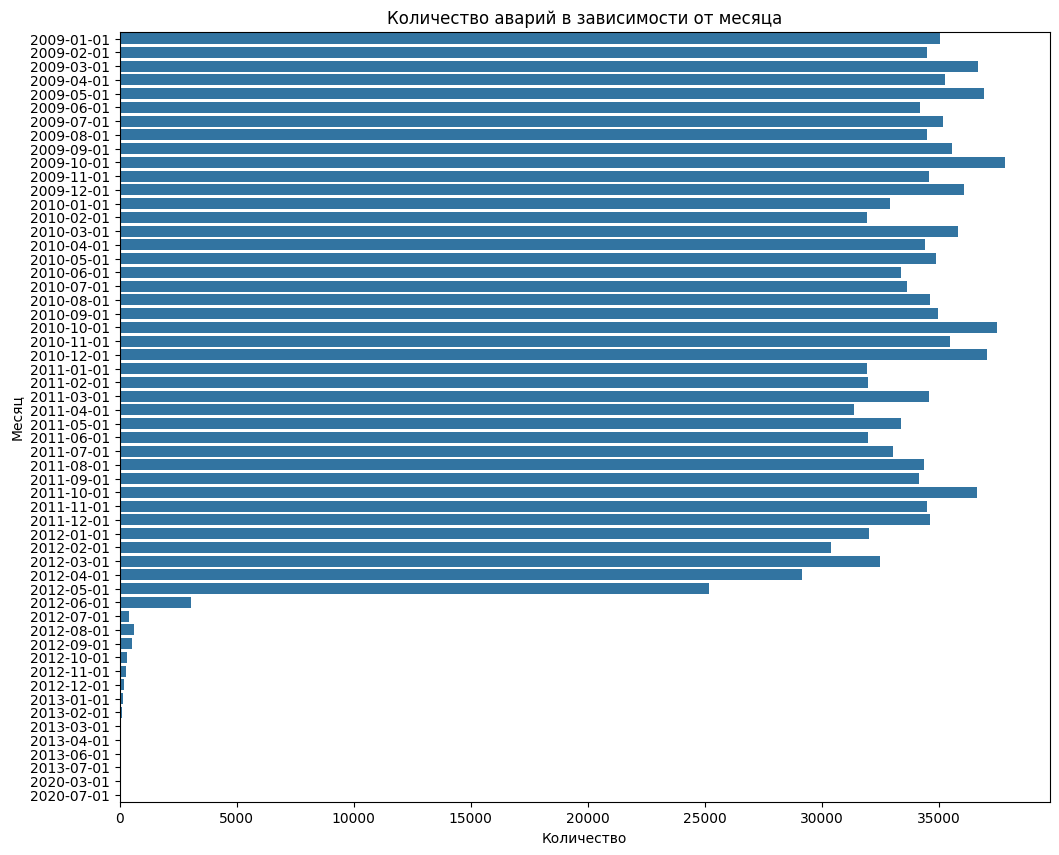

In [15]:
_, ax = plt.subplots(figsize=(12, 10))
sns.barplot(collisions_in_month, x='collision', y='month', ax=ax)
ax.set(
    xlabel='Количество',
    ylabel='Месяц',
    title='Количество аварий в зависимости от месяца'
);

По графику можно заметить начиная с июня 2012 года данные вообще практически перестали поступать в БД. Поэтому для получения релевантной картины необходимо исключить все данные позднее 2011 года.

In [16]:
collisions_in_month_before_2012_query = '''
SELECT EXTRACT(MONTH FROM collision_date)::integer AS month,
       COUNT(case_id) AS collision
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date) < 2012
GROUP BY EXTRACT(MONTH FROM collision_date)
'''
collisions_in_month_before_2012 = pd.read_sql_query(collisions_in_month_before_2012_query, engine)
collisions_in_month_before_2012

,month,collision
0,1,99880
1,2,98373
2,3,107036
3,4,101032
4,5,105148
5,6,99531
6,7,101835
7,8,103467
8,9,104649
9,10,111933


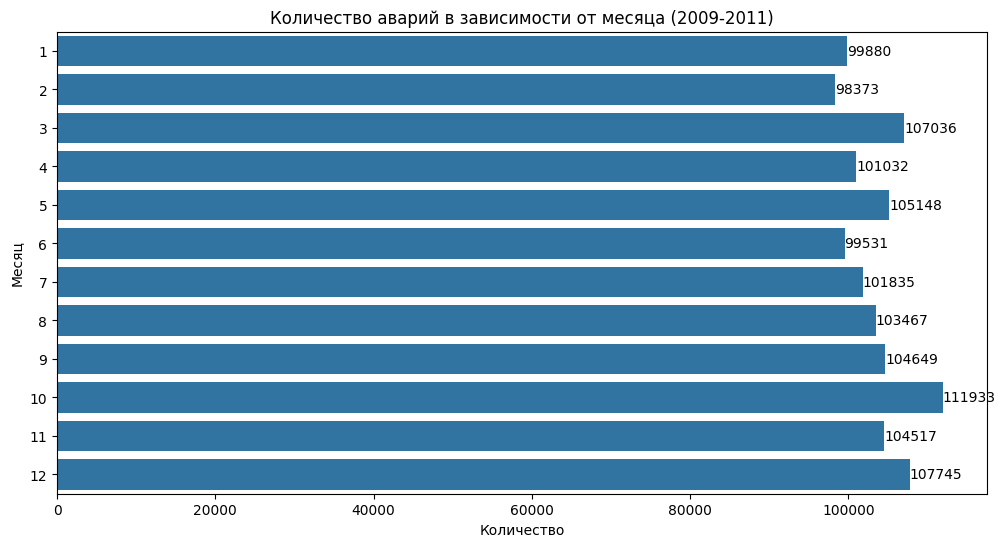

In [17]:
_, ax = plt.subplots(figsize=(12, 6))
sns.barplot(collisions_in_month_before_2012, x='collision', y='month', orient='y', ax=ax)
ax.set(
    xlabel='Количество',
    ylabel='Месяц',
    title='Количество аварий в зависимости от месяца (2009-2011)'
)
ax.bar_label(ax.containers[0], fontsize=10);

По графику можно заметить, что самыми аварийными являются месяцы октябярь, декабрь и март. Данную статистику можно объяснить тем, что в эти месяцы достаточно часто тяжелые погодные условия для передвижения на автомобиле (гололедица, снегопад и тд). Однако для более ясного понимания стоит изучить погодные условия в регионах, в которых фиксируются аварии (насколько я понимаю, все регионы относятся к Америке).  
Также стоит заметить, что в выгрузке присутствуют данные за 3 года. И разница между месяцами небольшая. Следовательно, можно предположить, что на вероятность аварии влияет не столько месяц, сколько погода на улице в момент поездки

## Задачи для коллег

1. Определить, есть ли зависимость между возрастом автомобиля и серьезностью проишествия    
2. Определить, автомобили с каким кузовом чаще всего попадают в аварию  
3. Определить, чаще ли нетрезвые водители попадают в аварию    
4. Определить, при каком освещении автомобилисты чаще попадают в аварию  
5. Определить, есть ли зависимость между наличием телефона в руках у водителя и вероятностью попасть а аварию  
6. Определить, при каком состоянии дороги автомобилисты чаше попадают в аварию  

## Влияет ли возраст автомобиля на серьезность аварии

In [18]:
vehicle_age_query = '''
SELECT v.case_id,
       v.vehicle_age,
       c.collision_damage
FROM vehicles AS v
JOIN collisions AS c ON v.case_id=c.case_id
'''
vehicle_age = pd.read_sql_query(vehicle_age_query, engine)
vehicle_age.head()

,case_id,vehicle_age,collision_damage
0,5305162,8.0,small damage
1,4091920,11.0,scratch
2,5305300,6.0,small damage
3,5365340,3.0,small damage
4,5366604,7.0,scratch


In [19]:
vehicle_age['vehicle_age'].max()

161.0

In [20]:
vehicle_age = vehicle_age.query('0 < vehicle_age <= 20')

In [21]:
vehicle_age.pivot_table(index='collision_damage', values='vehicle_age', aggfunc=['mean', 'median', 'count', 'min', 'max'])

,mean,median,count,min,max
,vehicle_age,vehicle_age,vehicle_age,vehicle_age,vehicle_age
collision_damage,,,,,
fatal,6.312614,6.0,14769,1.0,16.0
middle damage,5.350734,5.0,212657,1.0,20.0
scratch,5.673283,5.0,440656,1.0,20.0
severe damage,5.583091,5.0,39836,1.0,16.0
small damage,4.683649,4.0,248455,1.0,18.0


Можно заметить, что с увеличением серьезности происшествия средний возраст автомобиля увеличивается. Это не противоречит логике, ведь у более старых автомобилей больше износ деталей.

## Исследовать при каком освещении автомобилисты чаще попадают в аварии

In [22]:
vehicle_lighting_query = '''
WITH t1 AS(
    SELECT c.lighting,
           c.collision_damage,
           COUNT(c.case_id) AS count
    FROM parties AS p
    JOIN collisions AS c ON p.case_id=c.case_id
    WHERE p.party_type='car'
    GROUP BY c.lighting, c.collision_damage
)
SELECT *,
       SUM(count) OVER (PARTITION BY t1.lighting) AS count_lighting
FROM t1
'''
vehicle_lighting = pd.read_sql_query(vehicle_lighting_query, engine)
vehicle_lighting.head()

,lighting,collision_damage,count,count_lighting
0,dark with no street lights,fatal,3329,155827.0
1,dark with no street lights,middle damage,18656,155827.0
2,dark with no street lights,scratch,29694,155827.0
3,dark with no street lights,severe damage,5656,155827.0
4,dark with no street lights,small damage,98492,155827.0


In [23]:
vehicle_lighting = vehicle_lighting[~vehicle_lighting['lighting'].isna()]

In [24]:
vehicle_lighting['percent_damage'] = vehicle_lighting['count'] / vehicle_lighting['count_lighting'] 
vehicle_lighting.head()

,lighting,collision_damage,count,count_lighting,percent_damage
0,dark with no street lights,fatal,3329,155827.0,0.021363
1,dark with no street lights,middle damage,18656,155827.0,0.119723
2,dark with no street lights,scratch,29694,155827.0,0.190557
3,dark with no street lights,severe damage,5656,155827.0,0.036297
4,dark with no street lights,small damage,98492,155827.0,0.632060


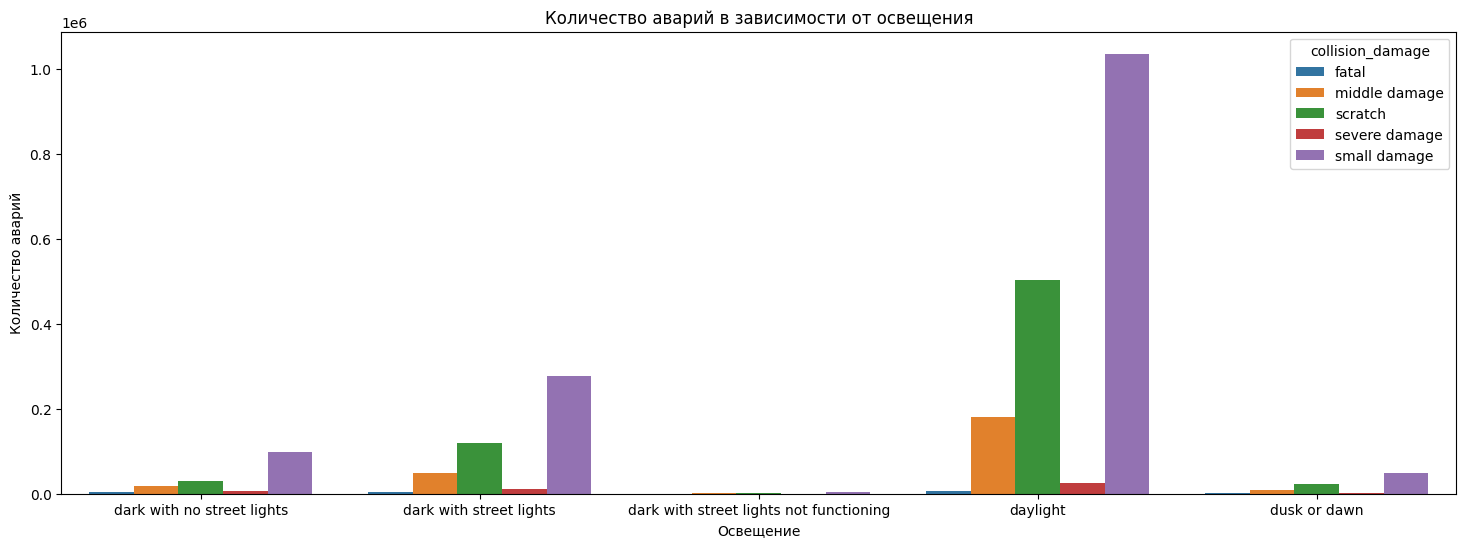

In [25]:
_, ax = plt.subplots(figsize=(18, 6))
sns.barplot(vehicle_lighting, x='lighting', y='count', hue='collision_damage', ax=ax)
ax.set(
    xlabel='Освещение',
    ylabel='Количество аварий',
    title='Количество аварий в зависимости от освещения'
);

Как можно заметить, большинство аварий происходят при дневном освещнее. Это можно объяснить тем, что в это время много машин на дороге и вероятность аварии повышается. При это странно, что на освешенных в темное время дня улицах аварии происходят чаще, чем на неосвещенных. Возможно, это тоже связано с тем, какое количество машин проезжает по темным улицам

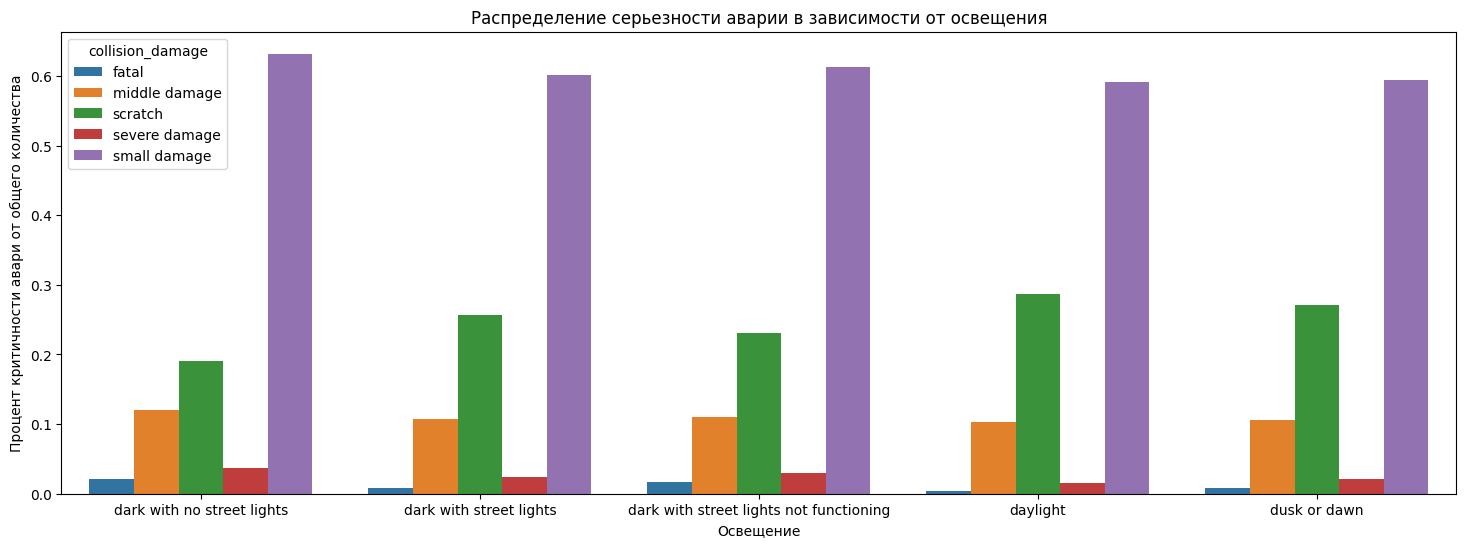

In [26]:
_, ax = plt.subplots(figsize=(18, 6))
sns.barplot(vehicle_lighting, x='lighting', y='percent_damage', hue='collision_damage', ax=ax)
ax.set(
    xlabel='Освещение',
    ylabel='Процент критичности авари от общего количества',
    title='Распределение серьезности аварии в зависимости от освещения'
);

По данному графику можно заметить, что от освещения не зависит серьезность аварии. При любом освещении чаще всего происзодят мелкие аварии

## Вывод

Из проведенного статистического анализа можно сделать следующие выводы:
1. По данным за 2009-2011 года больше всего аварий происходит в октябре, декабре, марте. Скорее всего, это связано с погодными условиями (гололед, снегопод и тд). Меньше всего аварий происходи в январе (скорее всего, связано с праздниками и тем, что люди в основном сидят дома), феврале (скорее всего, связано с тем, что месяц короткий) и июне (скорее всего, связано с тем, что люди уезжают в отпуска и реже ездят на машине). Также было замечено, что начиная с июня 2012 года количество записей в базе данных резко падает. Возможно, это связано со сбоями в БД или ее вообще перестали регулярно заполнять  
2. Можно заметить, что чем выше серьезность аварии, тем больше средний возраст автомобилей, попадающих в эти аварии. Возможно, это связано с большим износом деталей.  
3. Также были сделаны выводы о том, что чаще всего аварии происходят днем, когда на дорогах большая загрузка. При этом серьезность аварии не зависит от освещенности.

# Создайте модель для оценки водительского риска

Заказчиком выдвинты следующие требования к данным:
1. Выберите тип виновника — только машина (car).  
2. Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
3. Для моделирования ограничиться данными за 2012 год — они самые свежие (С учетом того, что за 2012 год данные есть только до июня, данное требование является странным и может привести к тому, что модель будет работать хуже в определенные месяцы).  
4. Учесть фактор возраста автомобиля  
  
Выгрузим данные с учетом требований заказчика

Из предоставленных нам таблиц возьмем все столбцы, кроме:
1. Из таблицы collisions:
    * COLLISION_DAMAGE - Серьёзность происшествия. Данную информацию можно определить только после аварии. Она никак не поможет предсказывать виновность водителя  
    * COUNTY_CITY_LOCATION - Номер географических районов, где произошло ДТП. Информация в данном столбце представлена в виде числа, а тип явно категориальный. Никак не поможет в поставленной задаче. 
    * PARTY_COUNT - Количество участников. Свершившийся факт после аварии. Никак не поможет в нашей задаче.  
    * TYPE_OF_COLLISION - Тип аварии. То, на какую часть автомобиля пришлась авария, никак не поможет нам предотавратить ее  
    * control_device - Устройство управления. Вообще не очень понятно, какую информацию несет данный столбец. Возможно, состояние автомобиля после аварии. В таком случае он нам точно ничем не поможет.  
2. Из таблицы parties:
    * PARTY_NUMBER - Номер участника происшествия. Тоже никак не поможет в нашей задаче
    * PARTY_TYPE - Тип участника происшествия. Так как по условию мы должны брать информацию только об автомобилях. Следовательно, этот столбец будет содержать только одно значение.  

In [27]:
data_query = '''
SELECT county_location,
       distance,
       direction,
       intersection,
       weather_1,
       location_type,
       primary_collision_factor,
       pcf_violation_category,
       motor_vehicle_involved_with,
       road_surface,
       lighting,
       collision_date,
       collision_time,
       at_fault,
       insurance_premium,
       party_sobriety,
       party_drug_physical,
       cellphone_in_use,
       vehicle_type,
       vehicle_transmission,
       vehicle_age
FROM (
    (SELECT *
	FROM collisions
	WHERE DATE_PART('year', collision_date) = 2012) AS c
	JOIN
	(SELECT *
	FROM parties
	WHERE party_type = 'car') AS p ON c.case_id = p.case_id
	JOIN
	(SELECT *
	FROM vehicles) AS v ON p.case_id = v.case_id)
WHERE collision_damage != 'scratch'
'''
df = pd.read_sql_query(data_query, engine)
df.head()

,county_location,distance,direction,intersection,weather_1,location_type,primary_collision_factor,pcf_violation_category,motor_vehicle_involved_with,road_surface,...,collision_date,collision_time,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,el dorado,200.0,north,0.0,clear,None,unknown,unknown,other motor vehicle,dry,...,2012-01-15,16:15:00,0,25.0,had not been drinking,None,0.0,sedan,manual,4.0
1,los angeles,1079.0,north,0.0,clear,None,vehicle code violation,improper passing,other motor vehicle,dry,...,2012-01-01,10:40:00,0,53.0,had not been drinking,None,0.0,sedan,manual,3.0
2,los angeles,1079.0,north,0.0,clear,None,vehicle code violation,improper passing,other motor vehicle,dry,...,2012-01-01,10:40:00,0,53.0,had not been drinking,None,0.0,coupe,manual,5.0
3,tulare,2112.0,west,0.0,cloudy,None,vehicle code violation,speeding,other motor vehicle,wet,...,2012-02-07,15:00:00,0,67.0,had not been drinking,None,0.0,coupe,auto,10.0
4,tulare,2112.0,west,0.0,cloudy,None,vehicle code violation,speeding,other motor vehicle,wet,...,2012-02-07,15:00:00,0,67.0,had not been drinking,None,0.0,sedan,auto,5.0


## EDA

In [28]:
start_dataset_size = df.shape[0]

ОБЩАЯ ИНФОРМАЦИЯ
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   county_location              118411 non-null  object 
 1   distance                     118411 non-null  float64
 2   direction                    89466 non-null   object 
 3   intersection                 118043 non-null  float64
 4   weather_1                    118022 non-null  object 
 5   location_type                55137 non-null   object 
 6   primary_collision_factor     118147 non-null  object 
 7   pcf_violation_category       116686 non-null  object 
 8   motor_vehicle_involved_with  118079 non-null  object 
 9   road_surface                 117645 non-null  object 
 10  lighting                     118080 non-null  object 
 11  collision_date               118411 non-null  object 
 12  collision_time          

,county_location,distance,direction,intersection,weather_1,location_type,primary_collision_factor,pcf_violation_category,motor_vehicle_involved_with,road_surface,...,collision_date,collision_time,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,el dorado,200.0,north,0.0,clear,None,unknown,unknown,other motor vehicle,dry,...,2012-01-15,16:15:00,0,25.0,had not been drinking,None,0.0,sedan,manual,4.0
1,los angeles,1079.0,north,0.0,clear,None,vehicle code violation,improper passing,other motor vehicle,dry,...,2012-01-01,10:40:00,0,53.0,had not been drinking,None,0.0,sedan,manual,3.0
2,los angeles,1079.0,north,0.0,clear,None,vehicle code violation,improper passing,other motor vehicle,dry,...,2012-01-01,10:40:00,0,53.0,had not been drinking,None,0.0,coupe,manual,5.0
3,tulare,2112.0,west,0.0,cloudy,None,vehicle code violation,speeding,other motor vehicle,wet,...,2012-02-07,15:00:00,0,67.0,had not been drinking,None,0.0,coupe,auto,10.0
4,tulare,2112.0,west,0.0,cloudy,None,vehicle code violation,speeding,other motor vehicle,wet,...,2012-02-07,15:00:00,0,67.0,had not been drinking,None,0.0,sedan,auto,5.0


|----------------------------------------------------------------------------------------------------|

КОЛИЧЕСТВО ДУБЛИКАТОВ
---------------------
2170
|----------------------------------------------------------------------------------------------------|

ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
--------------------
county_location                 0.000000
distance                        0.000000
direction                      24.444520
intersection                    0.310782
weather_1                       0.328517
location_type                  53.435914
primary_collision_factor        0.222952
pcf_violation_category          1.456790
motor_vehicle_involved_with     0.280379
road_surface                    0.646899
lighting                        0.279535
collision_date                  0.000000
collision_time                  0.108098
at_fault                        0.000000
insurance_premium               4.325612
party_sobriety                  1.460168
party_drug_physical            92.656

,distance,intersection,at_fault,insurance_premium,cellphone_in_use,vehicle_age
count,1.184110e+05,118043.000000,118411.000000,113289.000000,107507.000000,115046.000000
mean,7.320663e+02,0.234711,0.469686,38.624686,0.021320,4.908263
std,6.902704e+03,0.423820,0.499082,16.355164,0.144448,3.266265
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,0.000000,0.000000,25.000000,0.000000,3.000000
50%,1.180000e+02,0.000000,0.000000,36.000000,0.000000,4.000000
75%,5.280000e+02,0.000000,1.000000,50.000000,0.000000,7.000000
max,1.584000e+06,1.000000,1.000000,105.000000,1.000000,161.000000


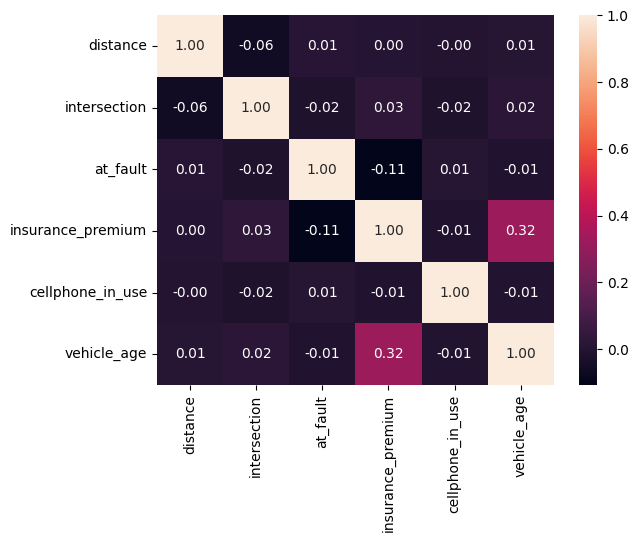

In [29]:
df_info(df)

В получившемся датасете присутствуют пропуски, дубликаты и несоответствие типов. Подробнее изучим каждый из признаков и исправим недостатки датасета

### county_location

Данный признак говорит нам о названии географических районов, где произошло ДТП. Конечно, в каждом из штатов может быть разная загруженность дорог и даже правила дорожного движения, а следовательно, вероятность аварии. Однако невозможно вместить в датасет каждый город. Считаю, что в таком виде данный признак не несет особой пользы. Удалим его из датасета

In [30]:
df.drop('county_location', axis=1, inplace=True)

### distance

Данный признак говорит нам о Расстояние от главной дороги (метры). Пропусков в данном столбце нет. Посмотрим на его распределение

In [31]:
distance_describe = df['distance'].describe()
distance_describe

count    1.184110e+05
mean     7.320663e+02
std      6.902704e+03
min      0.000000e+00
25%      2.000000e+00
50%      1.180000e+02
75%      5.280000e+02
max      1.584000e+06
Name: distance, dtype: float64

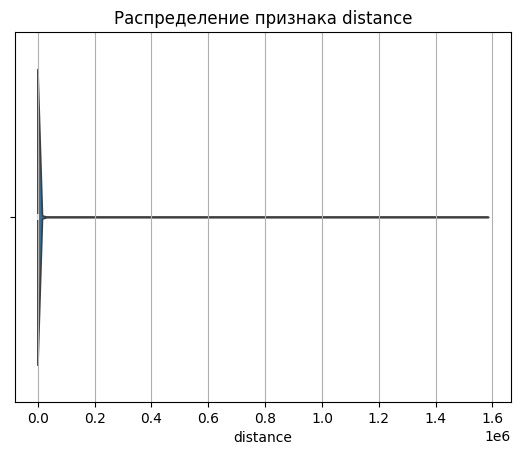

In [32]:
create_violinplot(df, 'distance')

Видно, что признак содержит аномальные значения в большую сторону. Посмотрим, какое количество данных лежит в 3 стандартных отклонениях

In [33]:
distance_std = distance_describe['std']
distance_mean = distance_describe['mean']
df.query('distance > @distance_mean + 3 * @distance_std')['distance'].count()

212

Так как не много записей содержат лежат вне 3 стандартных отклонений, то просто удалим их

In [34]:
df = df.query('distance < @distance_mean + 3 * @distance_std')

In [35]:
df['distance'] = df['distance'].astype('int32')

### direction

Данный столбец содержит информацию о направлении движения. В нем содержится 24.4% пропущенных значений. Это слишком большая часть датасета, чтобы удалить ее. Заполним пропуски значением `unknown`

In [36]:
df.loc[df['direction'].isna(), 'direction'] = 'unknown'

In [37]:
df['direction'] = df['direction'].astype('category')

### intersection

Данный столбец содержит информацию о том, является ли место происшествие перекрёстком. Сожержит 0.3% пропусков. Будем отталкиваться от того, что если не было указано, что это перекресток, то место ДТП не является перекрестком. Поэтому заполним пропуски 0

In [38]:
df.loc[df['intersection'].isna(), 'intersection'] = 1

In [39]:
df['intersection'] = df['intersection'].astype('int8')

### weather_1

Данный столбец содержит информацию о погоде. Содержит 0.3% пропусков. Восстановить данные не представляется возможным, а количество пропусков мало. Поэтому удалим пропущенные значения

In [40]:
df = df[~df['weather_1'].isna()]

In [41]:
df['weather_1'] = df['weather_1'].astype('category')

### location_type

Столбец содержит информацию о типе дороги. В столбце пропущено 53.4% данных. Удалять такое большое количество информации нельзя, поэтому заполним пропуски значением `unknown`

In [42]:
df.loc[df['location_type'].isna(), 'location_type'] = 'unknown'

In [43]:
df['location_type'] = df['location_type'].astype('category')

### primary_collision_factor

Данный признак отражает основной фактор аварии. Столбце содержит 0.22% пропусков. Так как пропусков немного и невозможно как-либо восстановить данные, удалим строки с пропущенным значением

In [44]:
df = df[~df['primary_collision_factor'].isna()]

In [45]:
df['primary_collision_factor'] = df['primary_collision_factor'].astype('category')

### pcf_violation_category

Данные признак отражает категорию нарушения. В столбце  содержится 1.46% пропущенных значений, что является все-таки достаточно большим количеством данных. Заполним пропуски значением `unknown`

In [46]:
df.loc[df['pcf_violation_category'].isna(), 'pcf_violation_category'] = 'unknown'

In [47]:
df['pcf_violation_category'] = df['pcf_violation_category'].astype('category')

### motor_vehicle_involved_with

Признак отражает дополнительных участников ДТП. Содержит 0.28% пропусков. Удалим строки с пропусками

In [48]:
df = df[~df['motor_vehicle_involved_with'].isna()]

In [49]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].astype('category')

### road_surface

Призак отражает состояние дороги. Содержит 0.65% пропусков. Удалим строки с пропущенными значениями

In [50]:
df = df[~df['road_surface'].isna()]

In [51]:
df['road_surface'] = df['road_surface'].astype('category')

### lighting

Призак отражает информацию об освещении дороги. Содержит 0.28% пропусков. Удалим строки с пропущенными значениями

In [52]:
df = df[~df['lighting'].isna()]

In [53]:
df['lighting'] = df['lighting'].astype('category')

### collision_date

Призак отражает даты проишествия ДТП. Не содержит пропусков. Однако так как в наших данных есть информация только за первые 5 месяцев года (из-за того, что по условию заказчика нужно использовать данные за 2012 год) мы не можем использовать данный признак в чистом виде. Однако можно попробовать использовать день недели, который можно получить из этого признака

In [54]:
week_day_dict = {
    0: 'monday',
    1: 'tuesday',
    2: 'wednesday',
    3: 'thursday',
    4: 'friday',
    5: 'saturday',
    6: 'sunday'
}

In [55]:
df['week_day'] = df['collision_date'].apply(lambda x: week_day_dict[x.weekday()])

In [56]:
df['week_day'] = df['week_day'].astype('category')
df.drop(['collision_date'], axis=1, inplace=True)

### collision_time

Признак отражает время происшествия. Содержит 0.1% пропусков, которые мы удалим. В чистом виде использовать призак не получится. Введем новые признак, который будет отражать утром, днем, вечером или ночью случилось ДТП

In [57]:
df = df[~df['collision_time'].isna()]

In [58]:
def time_of_day(time):
    if 0 <= time.hour <= 5:
        return 'night'
    if 6 <= time.hour <= 11:
        return 'morning'
    if 12 <= time.hour <= 18:
        return 'day'
    if 19 <= time.hour <= 23:
        return 'evening'
    return 'unknown'

In [59]:
df['collision_time'] = df['collision_time'].apply(time_of_day)

In [60]:
df['collision_time'] = df['collision_time'].astype('category')

### at_fault

Признак отражает виновность участника ДТП. Является целевым признаком. Пропусков нет. Проверим, нет ли аномальных значений

In [61]:
df['at_fault'].value_counts()

at_fault
0    61632
1    54708
Name: count, dtype: int64

Признак ожидаем содержит только значения 0 и 1. Причем можно заметить, что дисбаланса классов нет

In [62]:
df['at_fault'] = df['at_fault'].astype('int8')

### vehicle_age

Признак отражает возраст автомобиля. Столбец содержит 2.84% пропусков. К сожалению, восстановить данную информацию по имеющимся данным тяжело, поэтому удалим строки с пропусками

In [63]:
df = df[~df['vehicle_age'].isna()]

In [64]:
df['vehicle_age'].describe()

count    113080.000000
mean          4.907941
std           3.268920
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max         161.000000
Name: vehicle_age, dtype: float64

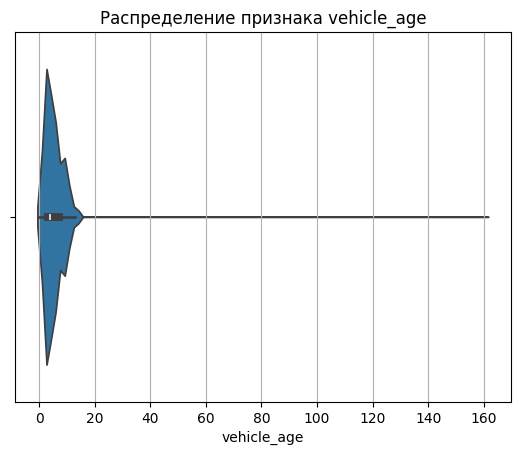

In [65]:
create_violinplot(df, 'vehicle_age')

Видно, что в данных присутствуют выбросы. В БД есть автомобили с возрастом до 161 года. Думаю, будет разумно ограничить возраст автомобиля 30 годами (вдруг раритетные автомобили тоже попадают в аварии)

In [66]:
df = df.query('vehicle_age <= 30')

In [67]:
df['vehicle_age'] = df['vehicle_age'].astype('int8')

### insurance_premium

Данные признак отражает сумму страховки. В столбце сожержится 4.33% пропущенных значений. Заполним пропуски медианным значением суммы страховки для каждого возраста

In [68]:
for age in df['vehicle_age'].unique():
    df.loc[(df['vehicle_age'] == age) & (df['insurance_premium'].isna() == True),
           'insurance_premium'] = \
    df.loc[(df['vehicle_age'] == age) & (df['insurance_premium'].isna() == False),
           'insurance_premium'].median()

In [69]:
df['insurance_premium'].describe()

count    113076.000000
mean         38.525978
std          16.155217
min           0.000000
25%          25.000000
50%          35.000000
75%          50.000000
max         105.000000
Name: insurance_premium, dtype: float64

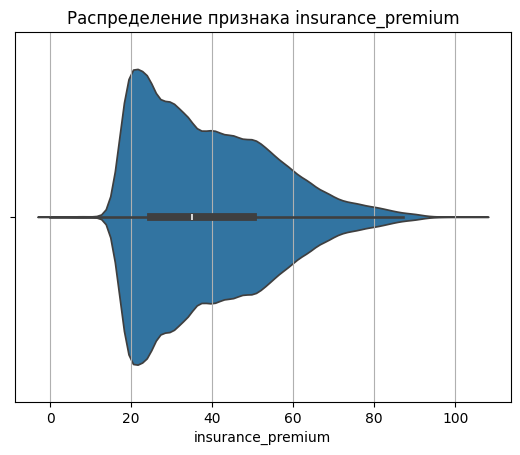

In [70]:
create_violinplot(df, 'insurance_premium')

Распределение данного признака похоже на нормальное с длинным правым хвостом. Максимальное значение страховки равно 105 тыс. Это может быть правдой, так как автомобили могут быть разной ценовой категории. Не будем удалять данные

In [71]:
df['insurance_premium'] = df['insurance_premium'].astype('int8')

### party_sobriety                  

Данный признак отражает трезвость водителя. Содержит 1.46% пропусков, которые заполним значением `unknown`

In [72]:
df.loc[df['party_sobriety'].isna(), 'party_sobriety'] = 'unknown'

In [73]:
df['party_sobriety'] = df['party_sobriety'].astype('category')

### party_drug_physical

Данный признак отражает состояние участника: физическое или с учётом принятых лекарств. Содержит большое количество пропусков - 92.65%. Заполним пропуски значением `G` - Impairment Unknown

In [74]:
df.loc[df['party_drug_physical'].isna(), 'party_drug_physical'] = 'G'

In [75]:
df['party_drug_physical'] = df['party_drug_physical'].astype('category')

### cellphone_in_use

Данный признак отражает наличие телефона в автомобиле (возможности разговаривать по громкой связи). Сожержит 9.2% пропусков. Пропуски заполним 0, так как нет доказательства, что водитель пользовался теелфоном

In [76]:
df.loc[df['cellphone_in_use'].isna(), 'cellphone_in_use'] = 0

In [77]:
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int')
df['cellphone_in_use'] = df['cellphone_in_use'].astype('category')

### vehicle_type

Признак отражает тип кузова автомобиля. Пропусков в столбце нет

In [78]:
df['vehicle_type'] = df['vehicle_type'].astype('category')

### vehicle_transmission

Данные признак отражает тип коробки передач автомобиля. Содержит 1.57% пропусков. Так как в БД нет никакой технической информации об автомобилях, восстановить данные мы не сможем. Придется удалить пропуски

In [79]:
df = df.loc[~df['vehicle_transmission'].isna()]

In [80]:
df['vehicle_transmission'] = df['vehicle_transmission'].astype('category')

### Удаление дубликатов

In [81]:
df = df.drop_duplicates().reset_index(drop=True)

### Результат

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109039 entries, 0 to 109038
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   distance                     109039 non-null  int32   
 1   direction                    109039 non-null  category
 2   intersection                 109039 non-null  int8    
 3   weather_1                    109039 non-null  category
 4   location_type                109039 non-null  category
 5   primary_collision_factor     109039 non-null  category
 6   pcf_violation_category       109039 non-null  category
 7   motor_vehicle_involved_with  109039 non-null  category
 8   road_surface                 109039 non-null  category
 9   lighting                     109039 non-null  category
 10  collision_time               109039 non-null  category
 11  at_fault                     109039 non-null  int8    
 12  insurance_premium            109039 non-null

In [83]:
print(f'После предобработки данных в датасете осталось {df.shape[0] / start_dataset_size:.2%} данных')

После предобработки данных в датасете осталось 92.09% данных


### Выводы

Был подготовлена датасет, удовлетворяющий требованиям заказчика:
1. Выбрать тип виновника — только машина (car).  
2. Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
3. Для моделирования ограничиться данными за 2012 год — они самые свежие (С учетом того, что за 2012 год данные есть только до июня, данное требование является странным и может привести к тому, что модель будет работать хуже в определенные месяцы).  
4. Учесть фактор возраста автомобиля  

 В ходе предобработки данных были устранены пропуски в данных, удалены выбросы и дубликаты. Удалось сохранить 92.09% данных

## Подготовка датасета и построение моделей

### Подготовка датасета

#### Разделение на выборки

In [84]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('at_fault', axis=1), df['at_fault'], test_size=.25,
    random_state=RANDOM_STATE, stratify=df['at_fault']
)

#### Масштабирование признаков

In [85]:
num_features = features_train.select_dtypes(include='number').columns.to_list()
num_features

['distance', 'intersection', 'insurance_premium', 'vehicle_age']

In [86]:
scaler = StandardScaler()
scaler.fit(features_train[num_features]);

In [87]:
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

#### Кодирование категориальных признаков

В проекте будут использованы модели, которые сами могут кодировать категориальные признаки (CatBoost), поэтому подготовим набор данных с закодированными признаками и без

In [88]:
cat_features = features_train.select_dtypes(include='category').columns.to_list()
cat_features

['direction',
 'weather_1',
 'location_type',
 'primary_collision_factor',
 'pcf_violation_category',
 'motor_vehicle_involved_with',
 'road_surface',
 'lighting',
 'collision_time',
 'party_sobriety',
 'party_drug_physical',
 'cellphone_in_use',
 'vehicle_type',
 'vehicle_transmission',
 'week_day']

In [89]:
features_train.head()

,distance,direction,intersection,weather_1,location_type,primary_collision_factor,pcf_violation_category,motor_vehicle_involved_with,road_surface,lighting,collision_time,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,week_day
18759,-0.158469,south,-0.543343,clear,highway,vehicle code violation,speeding,other motor vehicle,dry,dark with no street lights,evening,1.505892,had not been drinking,G,0,coupe,manual,-0.609907,sunday
78537,-0.098058,west,-0.543343,clear,highway,vehicle code violation,speeding,other motor vehicle,dry,daylight,day,-0.903721,had not been drinking,G,0,sedan,manual,0.025922,tuesday
88266,-0.281123,east,-0.543343,cloudy,highway,vehicle code violation,speeding,other motor vehicle,wet,dark with no street lights,night,-1.274431,had not been drinking,G,0,sedan,manual,-0.609907,saturday
101325,-0.342144,south,-0.543343,clear,highway,vehicle code violation,following too closely,other motor vehicle,dry,daylight,morning,-0.594797,had not been drinking,G,0,sedan,manual,0.025922,thursday
58928,-0.342144,north,-0.543343,clear,unknown,vehicle code violation,wrong side of road,bicycle,dry,daylight,day,-1.027291,had not been drinking,G,0,minivan,manual,0.661750,thursday


In [90]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [91]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', dtype='int')
encoder.fit(features_train_ohe[cat_features]);

In [92]:
features_train_ohe = ohe(features_train_ohe, encoder, cat_features)
features_test_ohe = ohe(features_test_ohe, encoder, cat_features)

### Выбор модели

В поставленной задача важны:
1. Precision. Так как, если мы будем отказывать всем клиентам в аренде машины, то бизнесс просто перестанет работать  
2. Recall. Так как, если мы будем без обдумывании риска всем давать машину, то аварии могут случаться слишком часто и будет много издержек на ремонт, а также риск человеческих жизней  
Однако эти риски не равнозначны. Лучше перестраховаться и не рисковать человеческими жизнями. Поэтому метрика recall должна иметь больший вес. Значит будем использовать взвешенной гармоническое с большим весом у recall. Для этого нам понадобится fbeta_score

In [93]:
f3_score = make_scorer(fbeta_score, beta=3, average='macro')

In [94]:
results = pd.DataFrame(
    columns=['f3_score_on_train', 'f3_score_on_test', 'training_time', 'prediction_time'],
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostRegressor']
)

#### LogisticRegression

In [95]:
pd.set_option('display.max_columns', None)

In [96]:
model_log_regression = LogisticRegression(
    max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1
)

In [97]:
if IS_TRAIN:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        log_reg_best_param = research_model(
            model_log_regression, GSCV_LOG_REGRESSION_CONFIG,
            features_train_ohe, target_train, f3_score
        ).head(10)
else:
    log_reg_best_param = pd.DataFrame(
        columns=['params', 'mean_train_score', 'mean_test_score', ],
        data=[[{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}, 0.668600, 0.668340 ]]
    )

In [98]:
log_reg_best_param[['params', 'mean_train_score', 'mean_test_score', ]].head()

,params,mean_train_score,mean_test_score
0,"{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.6686,0.66834


|params|	mean_train_score|	mean_test_score|
| :- | :- | :- |
|{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}|	0.668600|	0.668340|
|{'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}|	0.668669|	0.668284|
|{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}|	0.668676|	0.668230|
|{'C': 50, 'penalty': 'l2', 'solver': 'liblinear'}|	0.668688|	0.668185|
|{'C': 250, 'penalty': 'l1', 'solver': 'liblinear'}|	0.668688|	0.668177|

In [99]:
log_reg_best_param.reset_index(drop=True, inplace=True)

In [100]:
model_log_regression = LogisticRegression(
    max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1,
    **log_reg_best_param.loc[0, 'params']
)

In [101]:
start_train = time()
model_log_regression.fit(features_train_ohe, target_train)
end_train = time()
train_time_log_reg = round(end_train - start_train, 2)

In [102]:
start_predict = time()
model_log_regression.predict(features_train_ohe)
end_predict = time()
predict_time_log_reg = round(end_train - start_train, 2)

In [103]:
results.loc['LogisticRegression'] = [
    log_reg_best_param.loc[0, 'mean_train_score'],
    log_reg_best_param.loc[0, 'mean_train_score'],
    train_time_log_reg,
    predict_time_log_reg
]

#### RandomForestClassifier

In [104]:
model_rand_forest = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1,
)

In [105]:
if IS_TRAIN:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        rand_forest_best_param = research_model(
            model_rand_forest, GSCV_RAND_FOREST_CONFIG,
            features_train_ohe, target_train, f3_score
        )
else:
    rand_forest_best_param = pd.DataFrame(
        columns=['params', 'mean_train_score', 'mean_test_score', ],
        data=[[{'max_depth': 10, 'n_estimators': 26}, 0.683629, 0.677886 ]]
    )

In [106]:
rand_forest_best_param[['params', 'mean_train_score', 'mean_test_score', ]].head()

,params,mean_train_score,mean_test_score
0,"{'max_depth': 10, 'n_estimators': 26}",0.683629,0.677886


|params	|mean_train_score|	mean_test_score|
| :- | :- | :- |
|{'max_depth': 10, 'n_estimators': 26}|	0.683629|	0.677886|
|{'max_depth': 10, 'n_estimators': 131}|	0.683881|	0.677409|
|{'max_depth': 10, 'n_estimators': 81}|	0.682691|	0.676850|
|{'max_depth': 10, 'n_estimators': 121}|	0.683390|	0.676709|
|{'max_depth': 10, 'n_estimators': 136}|	0.683177	|0.676658|

In [107]:
rand_forest_best_param.reset_index(drop=True, inplace=True)

In [108]:
model_rand_forest = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1,
    **rand_forest_best_param.loc[0, 'params']
)

In [109]:
start_train = time()
model_rand_forest.fit(features_train_ohe, target_train)
end_train = time()
train_time_rand_forest = round(end_train - start_train, 2)

In [110]:
start_predict = time()
model_rand_forest.predict(features_train_ohe)
end_predict = time()
predict_time_rand_forest = round(end_train - start_train, 2)

In [111]:
results.loc['RandomForestClassifier'] = [
    rand_forest_best_param.loc[0, 'mean_train_score'],
    rand_forest_best_param.loc[0, 'mean_train_score'],
    train_time_rand_forest,
    predict_time_rand_forest
]

#### CatBoostRegressor

In [112]:
model_cat_boost = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=False,
    #task_type='GPU',
    cat_features=cat_features
)

In [113]:
if IS_TRAIN:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cat_boost_best_param = research_model(
            model_cat_boost, GSCV_CAT_BOOSRT_CONFIG,
            features_train, target_train, f3_score
        )
else:
    cat_boost_best_param = pd.DataFrame(
        columns=['params', 'mean_train_score', 'mean_test_score', ],
        data=[[
            {'learning_rate': 0.1, 'max_depth': 5,
             'min_data_in_leaf': 150, 'n_estimators': 400},
            0.709520, 0.702203
        ]]
    )

In [114]:
cat_boost_best_param[['params', 'mean_train_score', 'mean_test_score', ]].head()

,params,mean_train_score,mean_test_score
0,"{'learning_rate': 0.1, 'max_depth': 5, 'min_da...",0.70952,0.702203


|params	|mean_train_score|	mean_test_score|
| :- | :- | :- |
|{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 150, 'n_estimators': 400}|	0.709520|	0.702203|
|{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'n_estimators': 400}|	0.709290|	0.701921|
|{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 100, 'n_estimators': 400}|	0.709390|	0.701722|
|{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 50, 'n_estimators': 350}|	0.708652|	0.701588|
|{'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 100, 'n_estimators': 350}|	0.708634|	0.701575|

In [115]:
cat_boost_best_param.reset_index(drop=True, inplace=True)

In [116]:
model_cat_boost = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=False,
    #task_type='GPU',
    cat_features=cat_features,
    **cat_boost_best_param.loc[0, 'params']
)

In [117]:
start_train = time()
model_cat_boost.fit(features_train, target_train)
end_train = time()
train_time_cat_boost = round(end_train - start_train, 2)

In [118]:
start_predict = time()
model_cat_boost.predict(features_train)
end_predict = time()
predict_time_cat_boost = round(end_train - start_train, 2)

In [119]:
results.loc['CatBoostRegressor'] = [
    cat_boost_best_param.loc[0, 'mean_train_score'],
    cat_boost_best_param.loc[0, 'mean_train_score'],
    train_time_cat_boost,
    predict_time_cat_boost
]

#### Выбор модели

В итоге, выбранные модели показали следующие результаты

In [120]:
results.head()

,f3_score_on_train,f3_score_on_test,training_time,prediction_time
LogisticRegression,0.6686,0.6686,2.43,2.43
RandomForestClassifier,0.683629,0.683629,0.2,0.2
CatBoostRegressor,0.70952,0.70952,31.73,31.73


||f3_score_on_train|	f3_score_on_test|	training_time|	prediction_time|
| :- | :- | :- | :- | :-|
|LogisticRegression|	0.6686|	0.6686|	1.86|	1.86|
|RandomForestClassifier|	0.683629|	0.683629|	0.22|	0.22|
|CatBoostRegressor|	0.70952|	0.70952|	11.36|	11.36|

Можно заметить, что модель CatBoost показала лучшие результаты по выбранной метрике. Однако она значительно дольше обучается и выдает предсказания. Но так как заказчик не выдвигал никаких требований к времени обучения и предсказания, выберем модель с лучшим качествов - CatBoost

# Анализ работы лучшей модели

In [121]:
best_model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    verbose=False,
    task_type='GPU',
    cat_features=cat_features,
    **cat_boost_best_param.loc[0, 'params']
)
best_model.fit(features_train, target_train);

In [122]:
prediction = best_model.predict(features_test)

In [123]:
f3 = fbeta_score(target_test, prediction, beta=3)
recall = recall_score(target_test, prediction)
precision = precision_score(target_test, prediction)

In [124]:
print('Метрики лучшей модели на тестовой выборке:')
print(f'F_3: {f3:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')

Метрики лучшей модели на тестовой выборке:
F_3: 0.58
Recall: 0.56
Precision: 0.77


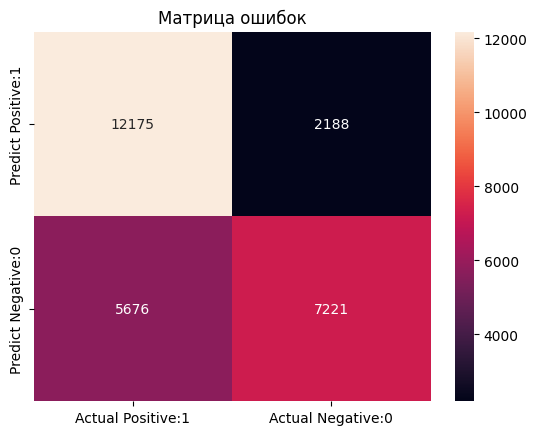

In [125]:
cm_matrix = pd.DataFrame(
    data=confusion_matrix(target_test, prediction), 
    columns=['Actual Positive:1', 'Actual Negative:0'], 
    index=['Predict Positive:1', 'Predict Negative:0']
)
cm_matrix
sns.heatmap(cm_matrix, annot=True, fmt='d').set_title('Матрица ошибок');

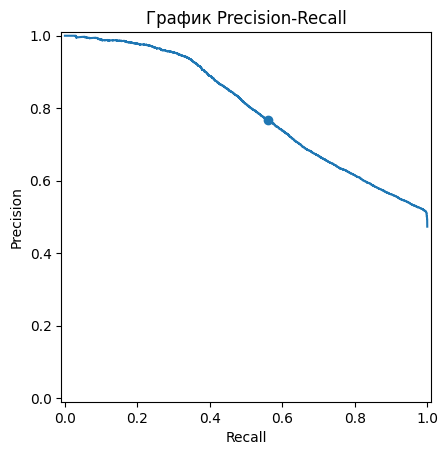

In [126]:
fpr, tpr, thresholds = roc_curve(target_test, best_model.predict_proba(features_test)[:, 1])

precision, recall, _ = precision_recall_curve(
    target_test,
    best_model.predict_proba(features_test)[:, 1]
)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(
    recall_score(target_test, prediction),
    precision_score(target_test, prediction)
)
plt.title('График Precision-Recall');

## Вывод

В ходе экспериментов было обучено 3 модели: LogisticRegression, RandomForestClassifier, CatBoostRegressor. Они показали следующие результаты:  
||f3_score_on_train|	f3_score_on_test|	training_time|	prediction_time|
| :- | :- | :- | :- | :-|
|LogisticRegression|	0.6686|	0.6686|	1.86|	1.86|
|RandomForestClassifier|	0.683629|	0.683629|	0.22|	0.22|
|CatBoostRegressor|	0.70952|	0.70952|	11.36|	11.36|  
  
Лучшая модель была проверена на тестовых данных. Были получены следующие метрики:
1. F_3: 0.55
2. Recall: 0.54
3. Precision: 0.76  
  
Не смотря на то, что при подборе гиперпараметров задавалось смещение в сторону метрики Recall, на тестовой выборке почему-то Precision оказался больше.  
Также были построены матрица ошибок и график `Precision-Recall`

# Проведите анализ важности факторов ДТП

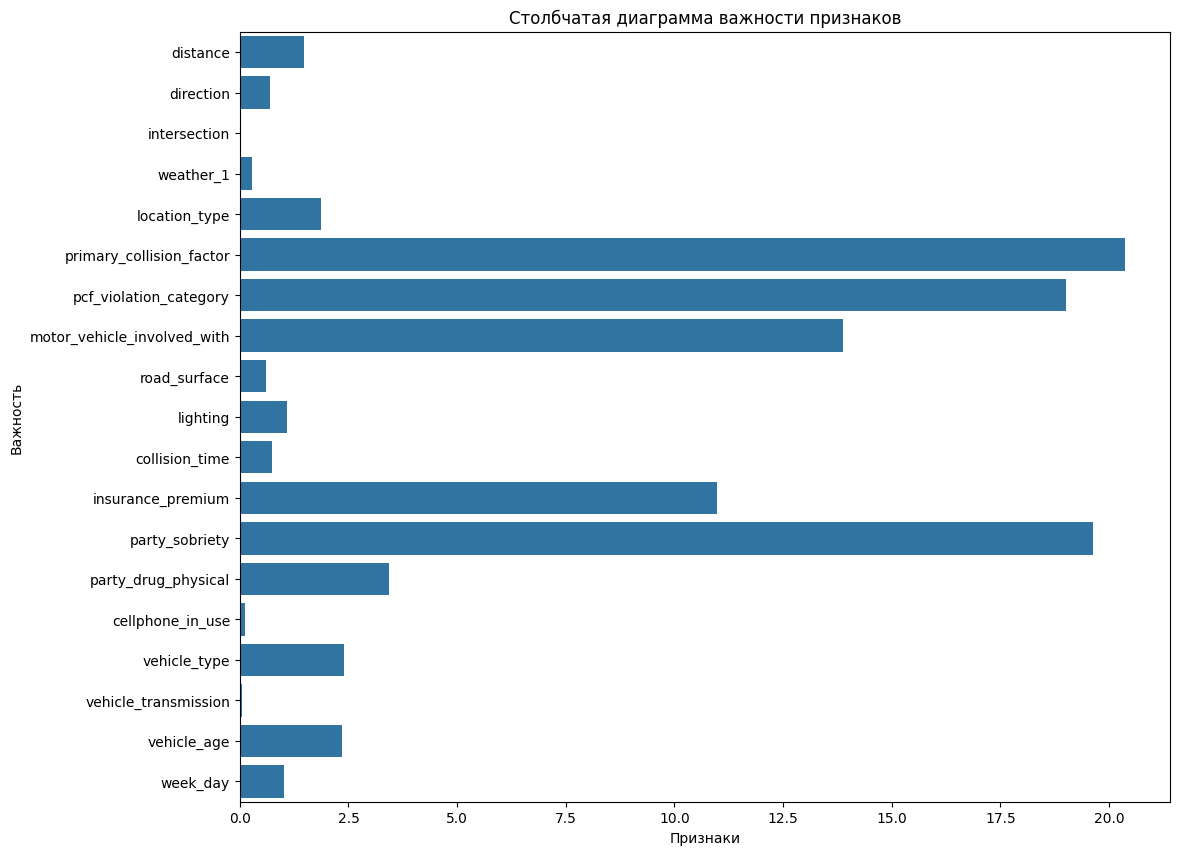

In [127]:
feature_importances = pd.Series(
    index=features_train.columns,
    data=best_model.feature_importances_
)

_, ax = plt.subplots(figsize=(12, 10))
sns.barplot(feature_importances, orient='y' )
ax.set(
    xlabel='Признаки',
    ylabel='Важность',
    title='Столбчатая диаграмма важности признаков'
);

График показал, что топ3 по важности признаками являются:
1. Трезвость водителя  
2. Основной фактор аварии  
3. Категория нарушений

# Выводы

В ходе работы было проведено исследование по оценке риска ДТП по заданному маршруту. Были достигнуты следующие результаты:
1. Изучены предоставленные данные. Выяснилось, что не все таблицы соответствуют заявленному описанию. Также оказалось, что данные стабильно поступали в БД только до середины 2012 года. Для улучшения качества исследования необходимо либо собрать более свежи данные. Либо договриться с заказчиком об обучении модели на данных 2009-2011 годов.  
2. Был проведен анализ признаков и выполнена предобработка данных: избавление от пропусков, удаление дубликатов. В результате предобработки удалось сохранить `92.09%` изначального датасета.
3. Была изучена работа 3 моделей LogisticRegression, RandomForestClassifier, CatBoostRegressor. Они показали следующие результаты:  

||f3_score_on_train|	f3_score_on_test|	training_time|	prediction_time|
| :- | :- | :- | :- | :-|
|LogisticRegression|	0.6686|	0.6686|	1.86|	1.86|
|RandomForestClassifier|	0.683629|	0.683629|	0.22|	0.22|
|CatBoostRegressor|	0.70952|	0.70952|	11.36|	11.36|  

Лучшая модель была проверена на тестовых данных. Были получены следующие метрики:
* F_3: 0.55
* Recall: 0.54
* Precision: 0.76  

4. Также была проанализирована важность признаков лучше модели. Топ3 самых важных признака: 
1. Трезвость водителя  
2. Основной фактор аварии  
3. Категория нарушений
  
<b>Итог</b>
Посталенная задача - оценка риска попасть в ДТП по выбранному маршруту, не может быть выполнена на данном датасете, так как в нем представлены только случаи, когда случилось ДТП. То есть мы получаем 100% дисбаланс классов. <b>Однако</b> может быть реализована другая задача - оценка риска, что водитель, взявший машину, будет виновником ДТП. Что может быть использовано в бизнес модели каршеринга. Опираясь на важность признаков можно предложить следующие меры для уменьшения вероятности ДТП по вине клиента:
1. При начале аренды машины проверять трезвость водителя
2. Периодически проверять знания клиента по правилам ПДД и исходя из этого назначать цену  